In [3]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
import sklearn.metrics as metrics


from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

%config InlineBackend.figure_format = 'svg'

In [4]:
df = pd.read_pickle('../emp_df_clean')
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,RandD,accounting,hr,management,marketing,product_mng,support,technical,left
0,0.38,0.53,2,157,3,0,0,1,0,0,0,0,0,0,0,0,1
1,0.80,0.86,5,262,6,0,0,2,0,0,0,0,0,0,0,0,1
2,0.11,0.88,7,272,4,0,0,2,0,0,0,0,0,0,0,0,1
3,0.72,0.87,5,223,5,0,0,1,0,0,0,0,0,0,0,0,1
4,0.37,0.52,2,159,3,0,0,1,0,0,0,0,0,0,0,0,1


## Feature Engineering Before Normalization

### Feature 1 - last_evaluation * number_project

In [5]:
df['int_term_1'] = df.last_evaluation * df.number_project

In [6]:
y = df['left']
X = df.drop(columns=['left', 'last_evaluation', 'number_project'])

- Ensure duplicate rows are not in test data

In [8]:
# finding duplicated rows
df_no_duplicates = df[df.duplicated()==False]
df_no_duplicates.shape

(11989, 18)

In [10]:
y = df_no_duplicates['left']
X = df_no_duplicates.drop(columns=['left'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

In [13]:
X.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years', 'salary', 'RandD', 'accounting', 'hr',
       'management', 'marketing', 'product_mng', 'support', 'technical',
       'int_term_1'],
      dtype='object')

KNN

In [14]:
# find out why f1 score gives knn n of 1
ks = range(1,20,2)
param_grid = [{'n_neighbors': ks}]

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', 
                       verbose=10, n_jobs=-1)
knn_results = knn_grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   19.0s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   20.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.9s finished


In [15]:
knn_results.best_params_

{'n_neighbors': 19}

In [16]:
knn_results.best_score_

0.9567687506982242

SVM

In [17]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = {'kernel': kernel}

svc = SVC(probability=True)
svc_grid = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc', 
                       verbose=10, n_jobs=-1)
svc_results = svc_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    9.4s remaining:   14.1s
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:   11.2s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:   14.6s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:   19.6s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   21.6s finished


In [18]:
svc_results.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [19]:
svc_results.best_params_

{'kernel': 'rbf'}

In [20]:
svc_results.best_score_

0.9632984556561321

Logistic Regression

In [25]:
penalty = ['l2', 'l2']
C = np.logspace(-3, 1, 100)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='liblinear', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1944s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1479s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 103 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 155 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 215 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 275 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 343 tasks      | elapsed:    5.2s
[Parallel(n_jo

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.09750e-03, ..., 9.11163e+00, 1.00000e+01]), 'penalty': ['l2', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [26]:
logistic_grid.best_estimator_

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [27]:
logistic_grid.best_score_

0.9240651410687356

Random Forest

In [28]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, None],
    'max_features': ['sqrt'], 
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [100, 200, 400, 1000]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:  1.7min
[Paralle

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [50, 100, None], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 5, 10], 'min_samples_split': [2, 3, 5, 10], 'n_estimators': [100, 200, 400, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [29]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
rf_grid.best_score_

0.9825801197741036

In [31]:
dummy = DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [32]:
print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
print('Best ROC_AUC for svm: %0.4f' % svc_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

Best ROC_AUC for knn: 0.9568
Best ROC_AUC for logit: 0.9241
Best ROC_AUC for svm: 0.9633
Best ROC_AUC for rf: 0.9826


In [33]:
# from sklearn.calibration import CalibratedClassifierCV
# clf = CalibratedClassifierCV(svc)
# clf.fit(X_train, y_train)

In [34]:
# clf.predict_proba(X_test)

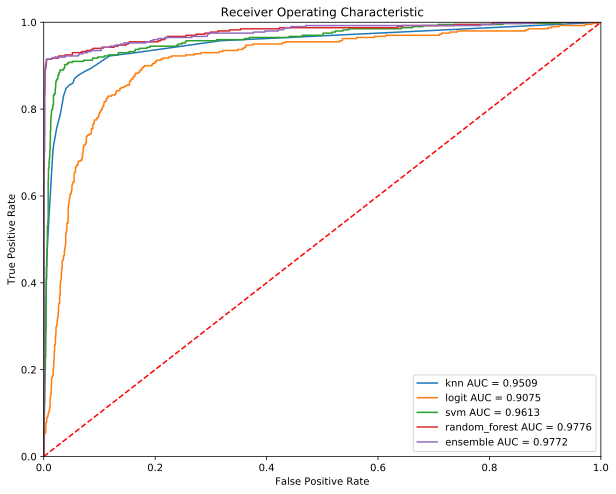

In [35]:
# ROC for all the models
model_list = [knn_grid.best_estimator_, 
              logistic_grid.best_estimator_, 
              svc_grid.best_estimator_, 
              rf_grid.best_estimator_,
              'ensemble']

model_name = ['knn', 'logit', 'svm', 'random_forest', 'ensemble']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.10
        w2 = 0.80
        y_pred = (w1*logistic_grid.best_estimator_.predict_proba(X_test)[:,1] 
                  + w2*rf_grid.best_estimator_.predict_proba(X_test)[:,1])
    else:
        # changed form model.predict_proba to clf.predict_proba
        y_pred = list(model.predict_proba(X_test)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Final dataset

In [36]:
df = pd.read_pickle('../emp_df_clean')
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,RandD,accounting,hr,management,marketing,product_mng,support,technical,left
0,0.38,0.53,2,157,3,0,0,1,0,0,0,0,0,0,0,0,1
1,0.80,0.86,5,262,6,0,0,2,0,0,0,0,0,0,0,0,1
2,0.11,0.88,7,272,4,0,0,2,0,0,0,0,0,0,0,0,1
3,0.72,0.87,5,223,5,0,0,1,0,0,0,0,0,0,0,0,1
4,0.37,0.52,2,159,3,0,0,1,0,0,0,0,0,0,0,0,1


In [ ]:
df.drop(columns=['last_evaluation', 'number_project'], inplace=True)

In [ ]:
df.to_pickle('emp_final_df')

In [ ]:
df.corr()